### Lesson 6 Assignment - Targeted Marketing Campaign
### Lawrence Huang
##### Instructions

Using the Bank Data csv file, create a new notebook to train, test, and evaluate an ensemble model. Perform each of the following tasks and answer the related questions:

1. Read in, parse, and pre-process the data
2. Perform a brief exploratory analysis
3. Compare the performance between a decision tree and a random forest approach by assessing the accuracy of each model
4. Graph the structure of your decision tree
5. Graph the confusion matrix of your random forest model

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import os
from IPython.display import Image

##### 1. Read in, parse, and pre-process the data

In [2]:
# load dataset
filename='https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Bank%20Data.csv'
df = pd.read_csv(filename)
# preview data
print('dataset shape:{}'.format(df.shape))
df.head()

dataset shape:(600, 11)


,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
0,48,FEMALE,INNER_CITY,17546.0,NO,1,NO,NO,NO,NO,YES
1,40,MALE,TOWN,30085.1,YES,3,YES,NO,YES,YES,NO
2,51,FEMALE,INNER_CITY,16575.4,YES,0,YES,YES,YES,NO,NO
3,23,FEMALE,TOWN,20375.4,YES,3,NO,NO,YES,NO,NO
4,57,FEMALE,RURAL,50576.3,YES,0,NO,YES,NO,NO,NO


In [3]:
# no obvious missing values
print('missing values by column:\n{}'.format(df.isna().sum()))

missing values by column:
age            0
sex            0
region         0
income         0
married        0
children       0
car            0
save_act       0
current_act    0
mortgage       0
pep            0
dtype: int64


In [4]:
# view data type and number of unique values/levels
print('Data type and # unique values/levels:')
pd.DataFrame({'data type':df.dtypes, 'unique levels':df.nunique()})

Data type and # unique values/levels:


,data type,unique levels
age,int64,50
sex,object,2
region,object,4
income,float64,599
married,object,2
children,int64,4
car,object,2
save_act,object,2
current_act,object,2
mortgage,object,2


In [5]:
# columns of object type: sex, region, married, car, save_act, current_act, mortgage, pep are categorical
# also encode children as there are only 4 unique levels
cols_to_encode = df.select_dtypes(include=['object']).columns.to_list()
cols_to_encode.append('children')
print('Columns to encode:\n{}'.format(cols_to_encode))

Columns to encode:
['sex', 'region', 'married', 'car', 'save_act', 'current_act', 'mortgage', 'pep', 'children']


##### 2. Perform a brief exploratory analysis

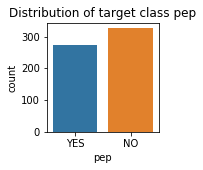

Fraction of yes: 0.46


In [6]:
# plot distribution of the target pep
fig, ax = plt.subplots(figsize=(2,2))
sns.countplot(x='pep', data=df, ax=ax)
plt.title('Distribution of target class pep')
plt.show()
print('Fraction of yes: {:.2f}'.format((df['pep']=='YES').sum()/df.shape[0]))

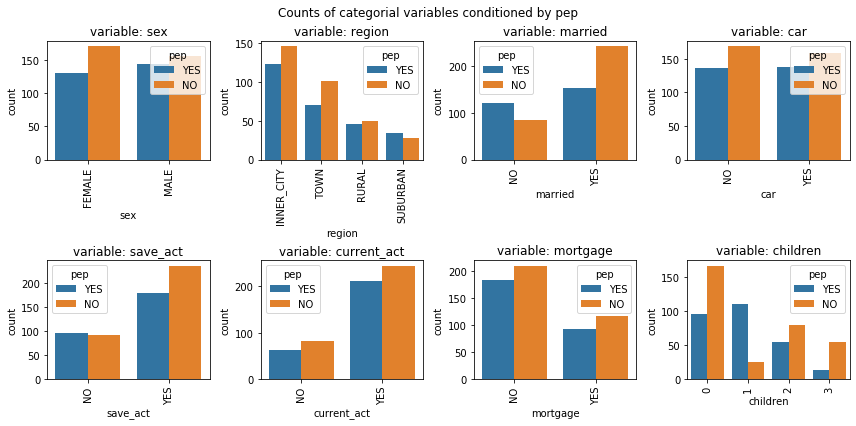

In [7]:
# examine categorial variables and relationship with pep
cols_to_plot = [xx for xx in cols_to_encode if xx != 'pep']
fig, ax = plt.subplots(2, 4, figsize=(12, 6))
for variable, subplot in zip(cols_to_plot, ax.flatten()):
    sns.countplot(x=variable, hue='pep', data=df, ax=subplot)
    subplot.set_title('variable: {}'.format(variable))
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
fig.tight_layout()
fig.suptitle('Counts of categorial variables conditioned by pep')
plt.subplots_adjust(top=0.9)
plt.show()

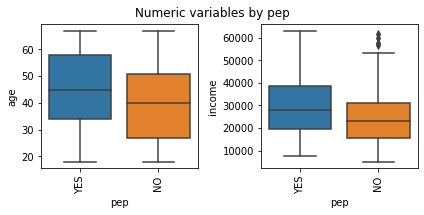

In [8]:
# examine numerical variables and relationship with pep
cols_to_plot = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
# children treated as categorical (4 unique levels)
cols_to_plot.remove('children') 
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
for variable, subplot in zip(cols_to_plot, ax.flatten()):
    sns.boxplot(x='pep', y=variable, data=df, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
fig.tight_layout()
fig.suptitle('Numeric variables by pep')
plt.subplots_adjust(top=0.9)
plt.show()

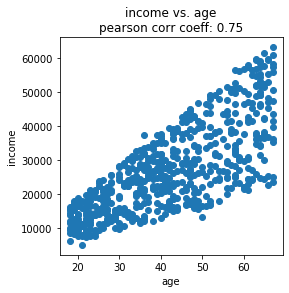

In [9]:
# examine correlation between the 2 numeric variables age and income
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(df['age'], df['income'])
ax.set_xlabel('age')
ax.set_ylabel('income')
ax.set_title('income vs. age\npearson corr coeff: {:.2f}'.format(df.corr()['age']['income']))
plt.show()

##### Qualitative observations from brief EDA:
<ul>
    <li>Target class (pep) distribution was fairly balanced</li>
    <li>pep: YES was relatively higher for customers in rural and suburban regions, who are not married, with no save_act, and with 1 child, when compared to other levels of the same variable</li>
    <li>pep: YES had higher age and income</li>
    <li>age and income are correlated (However, one might expect that if a decision tree used one of these variables then it would be less likely to use the other)</li>

###### Continue preprocessing...

In [10]:
# one hot encode categorical columns
df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)

# preview data
print('\ndataset shape after one hot encoding:{}'.format(df.shape))
df.head()


dataset shape after one hot encoding:(600, 15)


,age,income,sex_MALE,region_RURAL,region_SUBURBAN,region_TOWN,married_YES,car_YES,save_act_YES,current_act_YES,mortgage_YES,pep_YES,children_1,children_2,children_3
0,48,17546.0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,40,30085.1,1,0,0,1,1,1,0,1,1,0,0,0,1
2,51,16575.4,0,0,0,0,1,1,1,1,0,0,0,0,0
3,23,20375.4,0,0,0,1,1,0,0,1,0,0,0,0,1
4,57,50576.3,0,1,0,0,1,0,1,0,0,0,0,0,0


In [11]:
# train/test split
y = df['pep_YES'] # label
X = df.loc[:, ~df.columns.isin(['pep_YES'])] # features, use all but the target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=33)
print('features:\n{}'.format(X.columns.values))
print('\n# features: {}'.format(len(X.columns.values)))

features:
['age' 'income' 'sex_MALE' 'region_RURAL' 'region_SUBURBAN' 'region_TOWN'
 'married_YES' 'car_YES' 'save_act_YES' 'current_act_YES' 'mortgage_YES'
 'children_1' 'children_2' 'children_3']

# features: 14


In [12]:
# skip feature scaling
# decision tree models in general don't require feature scaling; no other models are being compared to here
if False:
    # standardize numeric columns (z-score)
    num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
    scaler = StandardScaler().fit(X_train[num_cols])
    X_train = X_train.copy()
    X_test = X_test.copy()
    X_train[num_cols] = scaler.transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

##### 3. Compare the performance between a decision tree and a random forest approach by assessing the accuracy of each model

In [13]:
# default tree using gini
print('Default gini decision tree')
clf_gini = DecisionTreeClassifier(criterion='gini', random_state=33).fit(X_train, y_train)
y_pred_gini = clf_gini.predict(X_test)
y_prob_gini = clf_gini.predict_proba(X_test)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_gini)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_gini).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_gini))

# determine the AUC
print('AUC score: {:.3f}'.format(roc_auc_score(y_test, y_prob_gini[:,1])))

# tree depth and # leaves
print('\nTree depth: {}, # leaves: {}'.format(clf_gini.get_depth(), clf_gini.get_n_leaves()))

Default gini decision tree

Confusion Matrix:
[[54 11]
 [ 7 48]]

TP, TN, FP, FN: 48 , 54 , 11 , 7

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        65
           1       0.81      0.87      0.84        55

    accuracy                           0.85       120
   macro avg       0.85      0.85      0.85       120
weighted avg       0.85      0.85      0.85       120

AUC score: 0.852

Tree depth: 16, # leaves: 95


In [14]:
# default tree using entropy 
print('Default entropy decision tree')
clf_ent = DecisionTreeClassifier(criterion='entropy', random_state=33).fit(X_train, y_train)
y_pred_ent = clf_ent.predict(X_test) 
y_prob_ent = clf_ent.predict_proba(X_test)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_ent)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_ent).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_ent))

# determine the AUC
print('AUC score: {:.3f}'.format(roc_auc_score(y_test, y_prob_ent[:,1])))

# tree depth and # leaves
print('\nTree depth: {}, # leaves: {}'.format(clf_ent.get_depth(), clf_ent.get_n_leaves()))

Default entropy decision tree

Confusion Matrix:
[[57  8]
 [ 7 48]]

TP, TN, FP, FN: 48 , 57 , 8 , 7

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        65
           1       0.86      0.87      0.86        55

    accuracy                           0.88       120
   macro avg       0.87      0.87      0.87       120
weighted avg       0.88      0.88      0.88       120

AUC score: 0.875

Tree depth: 14, # leaves: 93


In [15]:
# decision tree with tuned hyperparameters
# grid search parameters
parameters = [{'criterion': ['gini', 'entropy'],
               'max_leaf_nodes': range(5, 101, 5),
               'max_depth': range(4, 33, 4),
               'min_samples_leaf': range(1,16),
               'min_samples_split' : range(2,6)
              }]
print('The following hyperparameters were tuned:\n{}'.format(list(parameters[0].keys())))

The following hyperparameters were tuned:
['criterion', 'max_leaf_nodes', 'max_depth', 'min_samples_leaf', 'min_samples_split']


In [16]:
# grid search, fit and predict with best estimator
gs_tree = GridSearchCV(estimator=DecisionTreeClassifier(random_state=33),
                      param_grid=parameters, iid=False, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
gs_tree.fit(X_train, y_train)
y_pred_gstree = gs_tree.predict(X_test)
y_prob_gstree = gs_tree.predict_proba(X_test)

Fitting 3 folds for each of 19200 candidates, totalling 57600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 3969 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 13969 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 27969 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 45969 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 57600 out of 57600 | elapsed:   50.6s finished


In [17]:
# evaluate model using confusion matrix-derived metrics
print('Tuned decision tree')
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_gstree)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_gstree).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_gstree))

# determine the AUC
print('AUC score: {:.3f}'.format(roc_auc_score(y_test, y_prob_gstree[:,1])))

# tree depth and # leaves
print('\nTuned tree depth: {}, # leaves: {}'.format(gs_tree.best_estimator_.get_depth(), gs_tree.best_estimator_.get_n_leaves()))

# best tuned decision tree and hyperparameters
print('\nBest hyperparameters:\n{}'.format(gs_tree.best_params_))
print('\nBest tuned estimator:\n{}'.format(gs_tree.best_estimator_))

Tuned decision tree

Confusion Matrix:
[[56  9]
 [ 6 49]]

TP, TN, FP, FN: 49 , 56 , 9 , 6

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        65
           1       0.84      0.89      0.87        55

    accuracy                           0.88       120
   macro avg       0.87      0.88      0.87       120
weighted avg       0.88      0.88      0.88       120

AUC score: 0.907

Tuned tree depth: 7, # leaves: 15

Best hyperparameters:
{'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 15, 'min_samples_leaf': 5, 'min_samples_split': 2}

Best tuned estimator:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=15,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
            

In [18]:
# random forest
print('Default random forest model')
rf = RandomForestClassifier(n_estimators=20, random_state=33) # where 20 ~= sqrt of # observations
rf.fit(X_train, y_train)
print(rf)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_rf))

# determine the AUC
print('AUC score: {:.3f}'.format(roc_auc_score(y_test, y_prob_rf[:,1])))

Default random forest model
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=33, verbose=0,
                       warm_start=False)

Confusion Matrix:
[[57  8]
 [ 9 46]]

TP, TN, FP, FN: 46 , 57 , 8 , 9

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        65
           1       0.85      0.84      0.84        55

    accuracy                           0.86       120
   macro avg       0.86      0.86      0.86       120
weighted avg       0.86      0.86      0.86       120

AUC score: 0.909


In [19]:
# random forest with tuned hyperparameters, using the decision tree hyperparameters as a guide
# grid search parameters
parameters = [{'n_estimators': [10, 20, 50, 100, 200], # where 20 ~= sqrt of # observations
               'criterion': ['gini', 'entropy'], 
               'max_leaf_nodes': range(20, 51, 10),#101
               'max_depth': range(4, 33, 4),
               'min_samples_leaf': range(1,7),
               'min_samples_split' : range(2,6)
              }]
print('The following hyperparameters were tuned:\n{}'.format(list(parameters[0].keys())))

The following hyperparameters were tuned:
['n_estimators', 'criterion', 'max_leaf_nodes', 'max_depth', 'min_samples_leaf', 'min_samples_split']


In [20]:
# grid search, fit and predict with best estimator
gs_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=33),
                      param_grid=parameters, iid=False, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)
y_pred_gsrf = gs_rf.predict(X_test)
y_prob_gsrf = gs_rf.predict_proba(X_test)

Fitting 3 folds for each of 7680 candidates, totalling 23040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1696 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 3126 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 7126 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 9876 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 13126 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 16876 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 21126 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 23040 out of 23040 | elapsed:  4.5min finished


In [21]:
# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_gsrf)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_gsrf).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_gsrf))

# determine the AUC
print('AUC score: {:.3f}'.format(roc_auc_score(y_test, y_prob_gsrf[:,1])))

# best tuned decision random forest hyperparameters
print('\nBest hyperparameters:\n{}'.format(gs_rf.best_params_))
print('\nBest tuned estimator:\n{}'.format(gs_rf.best_estimator_))


Confusion Matrix:
[[59  6]
 [ 8 47]]

TP, TN, FP, FN: 47 , 59 , 6 , 8

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89        65
           1       0.89      0.85      0.87        55

    accuracy                           0.88       120
   macro avg       0.88      0.88      0.88       120
weighted avg       0.88      0.88      0.88       120

AUC score: 0.939

Best hyperparameters:
{'criterion': 'gini', 'max_depth': 16, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50}

Best tuned estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=50,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_

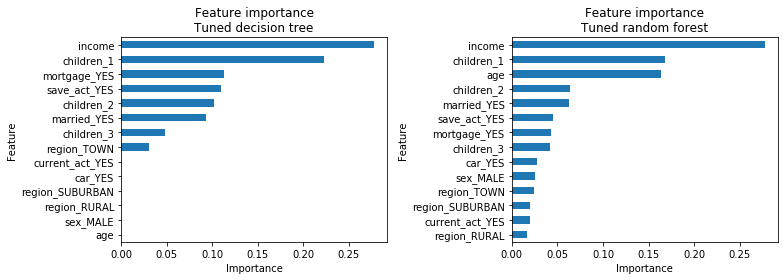

In [22]:
# plot feature importantance for tuned decision tree and random forest models
featimp_tree = pd.Series(index = X_train.columns, data = gs_tree.best_estimator_.feature_importances_)
featimp_rf = pd.Series(index = X_train.columns, data = gs_rf.best_estimator_.feature_importances_)
fig, axs = plt.subplots(1,2, figsize=(11,4))
featimp_tree.sort_values(ascending=False).plot(kind='barh', ax=axs[0])
featimp_rf.sort_values(ascending=False).plot(kind='barh', ax=axs[1])
for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
axs[0].set_title('Feature importance\nTuned decision tree')
axs[1].set_title('Feature importance\nTuned random forest')
fig.tight_layout()
plt.show()

In [23]:
# compare accuracy across models
model_results = pd.DataFrame({'Decision tree (gini/default param)': round(accuracy_score(y_test, y_pred_gini),3),
                              'Decision tree (ent/default param)': round(accuracy_score(y_test, y_pred_ent),3),
                              'Decision tree (tuned)': round(accuracy_score(y_test, y_pred_gstree),3),
                              'Random forest (20 estimators/default param)': round(accuracy_score(y_test, y_pred_rf),3),
                              'Randrom forest (tuned)': round(accuracy_score(y_test, y_pred_gsrf),3)
                             }, index=['Accuracy'])
model_results.T

,Accuracy
Decision tree (gini/default param),0.850
Decision tree (ent/default param),0.875
Decision tree (tuned),0.875
Random forest (20 estimators/default param),0.858
Randrom forest (tuned),0.883


##### Compare performances of decision tree and random forest models, assessed by accuracy:
<ul>
    <li>On this small dataset (600 total observations), accuracy on the test data was similar between all models used, ranging from 0.850-0.883</li>
    <li>The default decision tree model produced an accuracy of 0.850, whereas the default random forest model (using 20 estimators, ~= square root of the number of observations) produced an accuracy of 0.858
    <li>The tuned decision tree model produced an accuracy of 0.875, whereas the tuned random forest model produced an accuracy of 0.883</li>
    <li>Thus, on this test set the random forest model produced slightly higher accuracy compared to the decision tree model</li>
    </ul>

##### 4. Graph the structure of your decision tree

Visualization of the best/tuned decision tree:


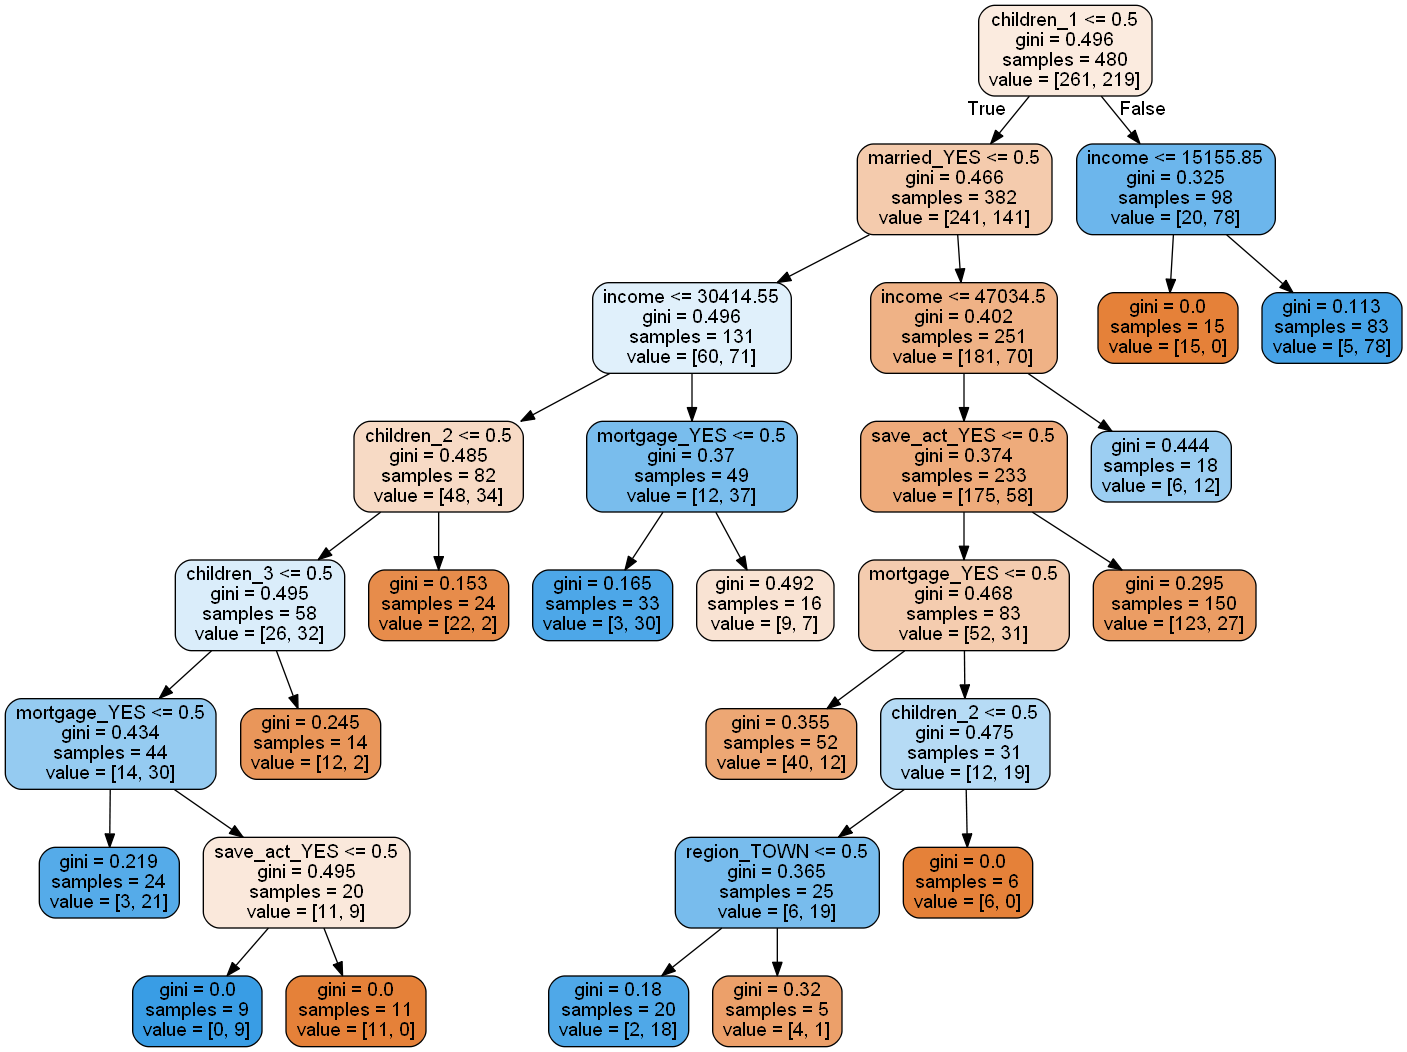

In [24]:
#create a visualization of the best/tuned decision tree 
dotfile = open("gs_tree.dot", 'w')
export_graphviz(gs_tree.best_estimator_, out_file=dotfile, filled=True, rounded=True, feature_names=X_train.columns)
dotfile.close()

# Convert the dot file to a png
os.system("dot -Tpng gs_tree.dot -o gs_tree.png");

# # Convert the dot file to a png
# from subprocess import check_call
# check_call(['dot','-Tpng','gs_tree.dot','-o','gs_tree.png'])

# show the png
print('Visualization of the best/tuned decision tree:')
Image(filename='gs_tree.png', width=1000, height=1000)

##### 5. Graph the confusion matrix of your random forest model

Confusion Matrix of tuned random forest model:
[[59  6]
 [ 8 47]]

TP, TN, FP, FN: 47 , 59 , 6 , 8


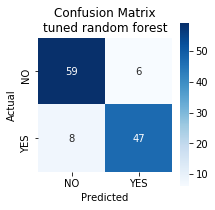

In [25]:
# confusion matrix of tuned random forest model
print ('Confusion Matrix of tuned random forest model:')
print(confusion_matrix(y_test, y_pred_gsrf)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_gsrf).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)

# generate a plot
fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(confusion_matrix(y_test, y_pred_gsrf), annot=True, ax=ax, square=True, cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix\ntuned random forest')
ax.xaxis.set_ticklabels(['NO', 'YES']); ax.yaxis.set_ticklabels(['NO', 'YES']);